# CONSTRUCTION OF FX VOL SURFACE - PART I

In this notebook I show how you can calibrate to the FX Vol Surface to ATM, 25D MS and 25D RR at one expiry date and analyse different volatility interpolation methods.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from financepy.utils import *
from financepy.models.FinModelBlackScholes import *
from financepy.products.fx import *
from financepy.market.curves import FinDiscountCurveFlat
from financepy.market.volatility import * 

## Load the Volatility Market Quotes

In [28]:
valuation_date = Date(10, 4, 2020)

In [29]:
forName = "EUR"
domName = "USD"
forCCRate = 0.03460  # EUR
domCCRate = 0.02940  # USD

We need to set up the option details - what you would find in the Term Sheet.

In [30]:
dom_discount_curve = FinDiscountCurveFlat(valuation_date, domCCRate)
for_discount_curve = FinDiscountCurveFlat(valuation_date, forCCRate)

In [31]:
currency_pair = forName + domName
spot_fx_rate = 1.3465        

I now load the option tenor, the ATM vol and the market strangle and risk-reversal quotes.

In [32]:
tenors = ['1Y']
atmVols = [18.250]
ms25DeltaVols = [0.95]
rr25DeltaVols = [-0.60]

We need to set some parameters for the vol surface.

In [33]:
notional_currency = forName
atmMethod = FinFXATMMethod.FWD_DELTA_NEUTRAL
deltaMethod = FinFXDeltaMethod.SPOT_DELTA

In [34]:
fxVolSurfaceClark = FinFXVolSurface(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                   dom_discount_curve, for_discount_curve,
                                   tenors, atmVols, ms25DeltaVols, rr25DeltaVols,
                                   atmMethod, deltaMethod, FinVolFunctionTypes.CLARK5)

In [35]:
fxVolSurfaceSABR = FinFXVolSurface(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                   dom_discount_curve, for_discount_curve,
                                   tenors, atmVols, ms25DeltaVols, rr25DeltaVols,
                                   atmMethod, deltaMethod, FinVolFunctionTypes.SABR)

In [36]:
fxVolSurfaceBBG = FinFXVolSurface(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                  dom_discount_curve, for_discount_curve,
                                  tenors, atmVols, ms25DeltaVols, rr25DeltaVols,
                                  atmMethod, deltaMethod, FinVolFunctionTypes.BBG)

We can examine the calibration

In [37]:
fxVolSurfaceClark.checkCalibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25D VOL:  0.950000 %
IN RSK REVERSAL 25D VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.934146 %
CNT_CPD_RF: 3.453111 %
FWD_RATE:   1.339530
VOL FUNCTION FinVolFunctionTypes.CLARK5
VOL_PARAMETERS: [-1.69813322e+00  1.08419662e-01  8.04374481e-01  3.28503702e-03
 -5.54285048e-04]
OUT_K_ATM:   1.362024
OUT_ATM_VOL: 18.249974 %
CALL_DELTA:  0.483029  PUT_DELTA: -0.483029  NET_DELTA: -0.000000
MKT STRANGLE VOL IN:  0.950000 %
K_25D_C_MS:  1.544954  ATM + MSVOL: 19.200000 %   DELTA:  0.250000
K_25D_P_MS:  1.205034  ATM + MSVOL: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043124  MS_VALUE:  0.078632
K_25D_C_MS:  1.544954  SURFACE_VOL: 18.923619 %   DELTA:  0.246191
K_25D_P_MS:  1.205034  SURFACE_VOL: 19.474793 %   DELTA: -0.252005
CALL_VALUE:  0.034350  PUT_VALUE: 

In [38]:
fxVolSurfaceSABR.checkCalibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25D VOL:  0.950000 %
IN RSK REVERSAL 25D VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.934146 %
CNT_CPD_RF: 3.453111 %
FWD_RATE:   1.339530
VOL FUNCTION FinVolFunctionTypes.SABR
VOL_PARAMETERS: [ 0.17431783  0.99987379 -0.11265088  0.81688325]
OUT_K_ATM:   1.362024
OUT_ATM_VOL: 18.250001 %
CALL_DELTA:  0.483029  PUT_DELTA: -0.483029  NET_DELTA:  0.000000
MKT STRANGLE VOL IN:  0.950000 %
K_25D_C_MS:  1.544954  ATM + MSVOL: 19.200000 %   DELTA:  0.250000
K_25D_P_MS:  1.205034  ATM + MSVOL: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043124  MS_VALUE:  0.078632
K_25D_C_MS:  1.544954  SURFACE_VOL: 18.925472 %   DELTA:  0.246216
K_25D_P_MS:  1.205034  SURFACE_VOL: 19.472884 %   DELTA: -0.251992
CALL_VALUE:  0.034358  PUT_VALUE:  0.044275  MS_SKEW_VALUE:  0.078632

In [39]:
fxVolSurfaceBBG.checkCalibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25D VOL:  0.950000 %
IN RSK REVERSAL 25D VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.934146 %
CNT_CPD_RF: 3.453111 %
FWD_RATE:   1.339530
VOL FUNCTION FinVolFunctionTypes.BBG
VOL_PARAMETERS: [ 0.15003521 -0.13816746  0.21407494]
OUT_K_ATM:   1.362024
OUT_ATM_VOL: 18.250002 %
CALL_DELTA:  0.483029  PUT_DELTA: -0.483029  NET_DELTA:  0.000000
MKT STRANGLE VOL IN:  0.950000 %
K_25D_C_MS:  1.544954  ATM + MSVOL: 19.200000 %   DELTA:  0.250000
K_25D_P_MS:  1.205034  ATM + MSVOL: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043124  MS_VALUE:  0.078632
K_25D_C_MS:  1.544954  SURFACE_VOL: 18.923432 %   DELTA:  0.246188
K_25D_P_MS:  1.205034  SURFACE_VOL: 19.474892 %   DELTA: -0.252006
CALL_VALUE:  0.034349  PUT_VALUE:  0.044283  MS_SKEW_VALUE:  0.078632
K_25D_C: 1.5

## Volatility Smile Analysis - Different Volatility Function Types

In [40]:
strikes = np.linspace(0.5, 2.5, 1000)

In [41]:
expiry_date = valuation_date.addTenor("1Y")

In [42]:
volsClark = []
volsSABR = []
volsBBG = []

for k in strikes:
    volClark = fxVolSurfaceClark.volatility(k, expiry_date)
    volSABR = fxVolSurfaceSABR.volatility(k, expiry_date)
    volBBG = fxVolSurfaceBBG.volatility(k, expiry_date)
    volsClark.append(volClark*100.0)    
    volsSABR.append(volSABR*100.0)    
    volsBBG.append(volBBG*100.0)    

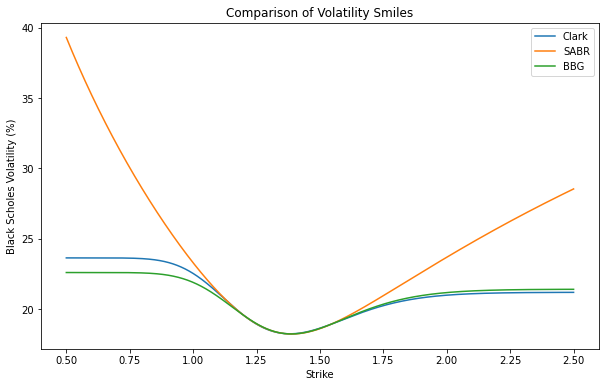

In [43]:
plt.figure(figsize=(10,6))
plt.plot(strikes, volsClark, label="Clark")
plt.plot(strikes, volsSABR, label="SABR")
plt.plot(strikes, volsBBG, label="BBG")
plt.xlabel("Strike")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Smiles")
plt.legend();

## Implied FX Rate Probability Density Functions

In [44]:
lower = 0.50
upper = 2.25
dbnClark = fxVolSurfaceClark.impliedDbns(lower, upper, 1000)
dbnSABR = fxVolSurfaceSABR.impliedDbns(lower, upper, 1000)
dbnBBG = fxVolSurfaceBBG.impliedDbns(lower, upper, 1000)

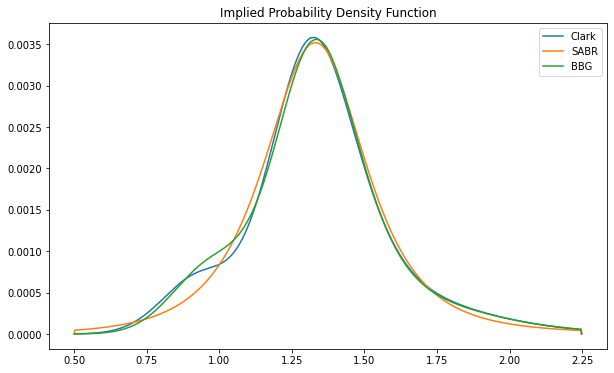

In [45]:
plt.figure(figsize=(10,6))
plt.plot(dbnClark[0]._x, dbnClark[0]._densitydx, label="Clark")
plt.plot(dbnSABR[0]._x, dbnSABR[0]._densitydx, label="SABR")
plt.plot(dbnBBG[0]._x, dbnBBG[0]._densitydx, label="BBG")
plt.title("Implied Probability Density Function")
plt.legend();

## Expiry Date Interpolation

We only have one expiry date. The volatility is therefore assumed to be flat at the level of this expiry date.

In [46]:
k = 1.30

In [47]:
years = np.linspace(0.0, 2.0, 100)

In [48]:
expiry_dates = valuation_date.addYears(years)

In [49]:
volsClark = []
volsSABR = []
volsBBG = []

for expiry_date in expiry_dates:
    
    volClark = fxVolSurfaceClark.volatility(k, expiry_date)
    volSABR = fxVolSurfaceSABR.volatility(k, expiry_date)
    volBBG = fxVolSurfaceBBG.volatility(k, expiry_date)

    volsClark.append(volClark*100.0)    
    volsSABR.append(volSABR*100.0)    
    volsBBG.append(volBBG*100.0)    

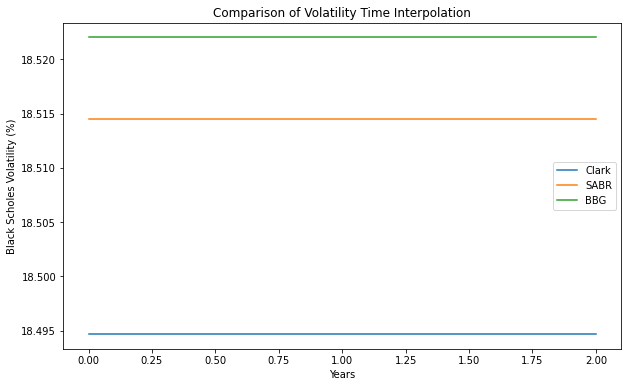

In [50]:
plt.figure(figsize=(10,6))
plt.plot(years, volsClark, label="Clark")
plt.plot(years, volsSABR, label="SABR")
plt.plot(years, volsBBG, label="BBG")
plt.xlabel("Years")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Time Interpolation")
plt.legend();

Copyright (c) 2020, Dominic O'Kane 